# Meiotic Homolog Pairing

In collaboration with the Burgess lab at UC Davis, we are interested in
simulating chromosomes diffusing in a budding yeast nucleus in order to compare to their single-particle tracking data of homologous (and heterologous) loci diffusing in early meiosis I.

We don't have concrete measurements of the viscoelasticity of these
nuclei, we will assume they are water-like (i.e. $\alpha = 1$ in a
fractional Langevin model of polymer diffusion). And since we are interested in
large-scale motion (frame rate in our real movies is already 30s), we can
simply use the Rouse model for the behavior of each chromosome.

## Testing Code

The :mod:`wlcsim.bd.rouse` module was originally written by Bruno Beltran to
replace Andrew Spakowitz/Steph Weber/Elena Koslover's FORTRAN77 Brownian
dynamics codebase for fractional ssWLC simulation. We want to do some tests so
make sure that the new code behaves as expected in all limiting cases with
known behavior.

### Rouse behavior

The simulations should reproduce the Gaussian statistics associated with a
Rouse polymer with the given parameters.

This includes an MSD that scales like

$$
        \begin{cases}
            6 D (N/\hat{N}) t \\
            1.9544100 b \sqrt{Dt} \\
            6(D/\hat{N}) t
        \end{cases}
$$

and Gaussian inter-bead distributions with mean spacing $L_0 b$.

In order to see this behavior, we turn off the confinement by setting the
strength of the confinement force `Aex` to 0, and do not tether any beads to
the confinement nor pair any loci together

In [32]:
np.log10(3000/dt)

8.075789505714491

In [30]:
dt

2.5196008663366337e-05

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import wlcsim
from wlcsim.bd import rouse, homolog

N = int(1e2+1); L = 17.475; b = 0.015; D = 2e1; R = 1;  # ChrV
dt = rouse.recommended_dt(N, L, b, D)
Aex = 0; # no confinement
N_tot, loop_list = homolog.points_to_loops_list(N, []) # no loops
tether_list = np.array([]).astype(int) # no tethered loci

The following derived parameters are explained in the docs for
:mod:`wlcsim.bd.rouse`.

In [2]:
Nhat = L/b; L0 = L/(N-1); Dhat = D*N/Nhat; bhat = np.sqrt(L0*b)

Saving all `1e6` time steps doesn't take up THAT much memory, but calculating the taMSD (a O(N^2) operation) for that many time points is prohibitive. 

We use `bnp.loglinsample` to save sets of equispaced time points (in chunks of length `Nlin`) that cover all time scales of our simulation. `Nlin` is chosen to be small enough that O(`Nlin`^2) is not too big.

You can think of `loglinsample` as returning a bunch of separate arrays

    1) `np.arange(0, dt*Nlin, dt)`
    2) `np.arange(0, dt*Nlin**2, Nlin*dt)`
    3) ...
    4) `np.linspace(0, Nt*dt, Nlin)`
    
we will compute the MSD using the equally-spaced points in each of these arrays, then recombine that into a single curve below.


In [17]:
Nt = 1e6; # total number of equi-space time steps
Nlin = 1e4; # see docstring of loglinsample
t = np.arange(0, Nt*dt, dt) # take Nt time steps
from bruno_util import numpy as bnp
t_i, i_i = bnp.loglinsample(Nt, Nlin, 0.6)
t_save = t[t_i]

In [18]:
i_i = [np.round(i).astype(int) for i in i_i] # numba workaround

Simulate for long enough to see the cross-over into the :math:`t^{1/2}` regime.
(This simulation takes about 4min on my laptop).

In [5]:
# run actual simulation
x = homolog._jit_rouse_homologs(N, N_tot, tether_list, loop_list, L, b, D, Aex, R, R, R, t, t_save)
# TODO:
x = rouse.with_integrator(runge_kutta.srk1/runge_kutta.lena4)

Post-processing simulation a score or so seconds per `_get_bead_msd` call (time averaged MSD calculation is expensive)

In [6]:
import wlcsim.bd.runge_kutta
sim_ts = []
sim_msds = []
for i in i_i:
    sim_ts.append(t_save[i])
    # extract msd of 51st (of 101) bead from simulation
    m, c = wlcsim.bd.runge_kutta._get_bead_msd(x[i], )
    sim_msds.append(m/c)


First plot the MSD curves separately, to demonstrate that the clever time-point choice worked correctly

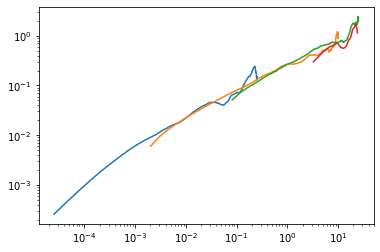

In [9]:
for t, msd in zip(sim_ts, sim_msds):
    plt.plot(t[1:], msd[1:])
plt.yscale('log'); plt.xscale('log')

now combine them altogether (this is what you would normally do)

In [47]:
sim_msd = np.zeros_like(t_save)
# for each set of equi-spaced time points we used
for i in i_i:
    # extract msd of 51st (of 101) bead from simulation
    m, c = wlcsim.bd.runge_kutta._get_bead_msd(x[i], 51)
    # recombine into single array, overwriting values computed from
    # more tightly-space points with those from less tightly-spaced
    sim_msd[i[1:]] = m[1:]/c[1:]


compare MSD curves to analytical result (by truncating/choosing a finite number of modes matching N/2 beads, we recover the exact analytical theory for a finite rouse chain from that of the infinite chain)


In general, if you have a statistical quantity

$$
\hat{X}(t)
$$

want to match, moments, but there are many types of moments...

You can increase the "order" of the moments:

$$
<X_s(t)>, <X_s^2(t)>, \ldots, <X_s^n(t)>
$$

You can apply increasing numbers of finite derivatives before taking the moment:

$$ MSD(t) = <(X_s(t+\tau) - X_s(\tau))^2>$$
$$ \text{Chain correlation}(ds) = <(X_{s+ds}(t) - X_s(t))^2>$$

The finite derivative can also be taken inside the parenthesis:

e.g. 
$$ <X_{s+ds}(t)X_s(t)>$$
or
$$ \text{Position correlation}(t) = <X(\tau)X(t+\tau)>$$


If you're lucky, then you can also try to match the Green's function

$$
P(X_s(t) = x | X_s(0) = x_0)
$$

In general you can't *look* at the Green's function for all of $X$.




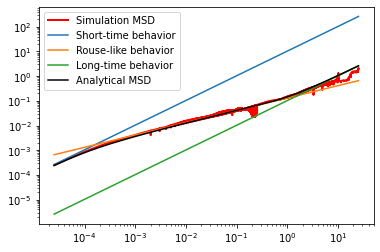

In [49]:
import matplotlib.pyplot as plt

plt.plot(t_save[1:], sim_msd[1:], 'r', label='Simulation MSD', lw=2)


# exclude t=0 to make log/log msd look good
plt.plot(t_save[1:], 6*D*(N/Nhat)*t_save[1:], label='Short-time behavior')
plt.plot(t_save[1:], 1.9544100*b*np.sqrt(D*t_save[1:]), label='Rouse-like behavior')
plt.plot(t_save[1:], 6*D*t_save[1:]/Nhat, label='Long-time behavior')
plt.plot(t_save[1:], wlcsim.analytical.rouse.linear_mid_msd(t_save[1:],
		b, Nhat, D, num_modes=int(N/2)), 'k', label='Analytical MSD')


plt.yscale('log'); plt.xscale('log');
plt.legend()

### Ornstein-Uhlenbeck test

Two-bead chains can be well understood as an Ornstein-Uhlenbeck process in the
coordinates of one of the beads. The position autocorrelation of the second bed
should be an exponential

$$ \langle x_s - x_0, x_t - x_0 \rangle = \frac{k_B T}{k} \exp\left(-k|t|/\xi\right) $$


In [2]:
import scipy.optimize

In [3]:
scipy.optimize.curve_fit?

In [3]:
N = 2; L = 3; R = 1000; b = 1; D = 5 # two O-U processes
dt = rouse.recommended_dt(N, L, b, D)
Aex = 0; # no confinement
N_tot, loop_list = rouse.homolog_points_to_loops_list(N, []) # no loops
tether_list = np.array([]).astype(int) # no tethered loci

we run 100 copies of the process, to get better stats (so 200 total 3D O-U processes, since each simulation has two "homologs")

In [4]:
Nt = 1e4;
t = np.arange(0, Nt*dt, dt) # take Nt time steps
X = []
for i in range(100):
    x = rouse._jit_rouse_homologs(N, N_tot, tether_list, loop_list, L, b, D, Aex, R, R, R, t, t)
    X.append(np.stack([x[:,1,:] - x[:,0,:], x[:,3,:] - x[:,2,:]]))
X = np.concatenate(X, axis=0)

In [7]:
X.shape # (num_samples, num_t, d)

(200, 10000, 3)

In [6]:
# abuse get_bead_msd, which expects X.shape == (num_t, num_beads, d)
# to get one of the sample's MSDs by pretending its a "bead"
sim_msd, count = wlcsim.bd.runge_kutta._get_bead_msd(np.transpose(X, [1, 0, 2]), 1)

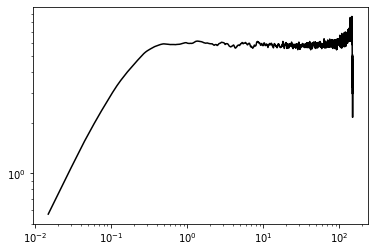

In [8]:
plt.plot(t[1:], sim_msd[1:]/count[1:], 'k')
plt.yscale('log'); plt.xscale('log')

Make sure that the position correlation function
$$ <X(\tau)X(t+\tau)>$$
matches the expectation for a OU process

In [9]:
corr, count = wlcsim.bd.runge_kutta._get_vector_corr(X)

(0.0001, 10.0)

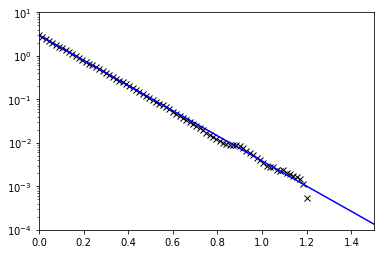

In [25]:
Nhat = L/b; L0 = L/(N-1); Dhat = D*N/Nhat; bhat = np.sqrt(L0*b)
plt.plot(t, corr/count, 'kx')
kbT_over_k = 3*bhat**2/3 # bhat**2/3 per dimension
k_over_xi = 3*(2*Dhat)/bhat**2 # extra (2*Dhat) because it's two beads tethered, not one tether to origin
plt.plot(t, kbT_over_k * np.exp(-k_over_xi*t), 'b')
plt.yscale('log')
plt.xlim([0, 1.5])
plt.ylim([1e-4, 1e1])

###  Confinement

As seen above, if the confinement size is made "weak enough", the simulation
behaves as it should in the absense of a confinement.

The MSD should plateau at the radius of the confinement.

In [29]:
N = int(1e2+1); L = 17.475; R = 1.000; b = 0.015; D = 2e1 # ChrV
dt = rouse.recommended_dt(N, L, b, D)
Aex = 100; # multiplier on confinement force
N_tot, loop_list = rouse.homolog_points_to_loops_list(N, []) # no loops
tether_list = np.array([]).astype(int) # no tethered loci

In [35]:
Nt = 1e8; Nt_save = 1e4;
t = np.arange(0, Nt*dt, dt) # take Nt time steps
t_save = t[::int(Nt/Nt_save)] # save only a subsample
# run actual simulation
x = rouse._jit_rouse_homologs(N, N_tot, tether_list, loop_list, L, b, D, Aex, R, R, R, t, t_save)

In [36]:
# extract msd of 51st (of 101) bead from simulation
sim_msd, count = wlcsim.bd.runge_kutta._get_bead_msd(x, 51)

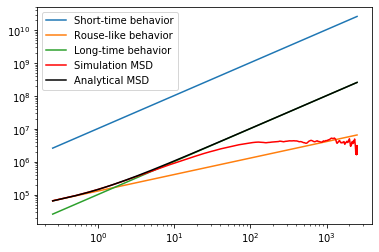

In [37]:
Nhat = L/b; L0 = L/(N-1); Dhat = D*N/Nhat; bhat = np.sqrt(L0*b)
# exclude t=0 to make log/log msd look good
plt.plot(t_save[1:], 6*D*(N/Nhat)*t_save[1:], label='Short-time behavior')
plt.plot(t_save[1:], 1.9544100*b*np.sqrt(D*t_save[1:]), label='Rouse-like behavior')
plt.plot(t_save[1:], 6*D*t_save[1:]/Nhat, label='Long-time behavior')
plt.plot(t_save[1:], sim_msd[1:]/count[1:], 'r', label='Simulation MSD')
plt.plot(t_save[1:], wlcsim.analytical.rouse.rouse_mid_msd(t_save[1:],
		b, Nhat, D, num_modes=int(N/2)), 'k', label='Analytical MSD')
plt.yscale('log'); plt.xscale('log');
plt.legend()

Beads that are "tethered" to the confinement should be preferentially "close"
to it compared to the rest of the beads in the simulation.

In [51]:
N = int(1e2+1); L = 17.475; R = 1.000; b = 0.015; D = 2e1 # ChrV
dt = rouse.recommended_dt(N, L, b, D)
Aex = 100; # multiplier on confinement force
N_tot, loop_list = rouse.homolog_points_to_loops_list(N, []) # no loops
tether_list = np.array([0, 51, 100]).astype(int) # tethered telomeres and centromere

In [52]:
%%debug
Nt = 1e6; Nt_save = 1e4;
t = np.arange(0, Nt*dt, dt) # take Nt time steps
t_save = t[::int(Nt/Nt_save)] # save only a subsample
# run actual simulation
x = rouse._jit_rouse_homologs(N, N_tot, tether_list, loop_list, L, b, D, Aex, R, R, R, t, t_save)

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(2)<module>()

ipdb> s
> <string>(3)<module>()

ipdb> s
> <string>(4)<module>()

ipdb> 
> <string>(6)<module>()

ipdb> 
--Call--
> /home/bbeltr1/.miniconda/lib/python3.7/site-packages/numba/dispatcher.py(521)typeof_pyval()
    519         return "%s(%s)" % (type(self).__name__, self.py_func)
    520 
--> 521     def typeof_pyval(self, val):
    522         """
    523         Resolve the Numba type of Python value *val*.

ipdb> n
> /home/bbeltr1/.miniconda/lib/python3.7/site-packages/numba/dispatcher.py(529)typeof_pyval()
    527         # Not going through the resolve_argument_type() indirection
    528         # can save a couple µs.
--> 529         try:
    530             tp = typeof(val, Purpose.argument)
    531         except ValueError:

ipdb> 
> /home/bbeltr1/.miniconda/lib/python3.7/site-packages/numba/dispatcher.py(530)typeof_pyval()
    528         # can save a couple µs.
    529         try:
--> 530     

ipdb> 
> /home/bbeltr1/.miniconda/lib/python3.7/site-packages/numba/dispatcher.py(347)_compile_for_args()
    345         argtypes = []
    346         for a in args:
--> 347             if isinstance(a, OmittedArg):
    348                 argtypes.append(types.Omitted(a.value))
    349             else:

ipdb> 
> /home/bbeltr1/.miniconda/lib/python3.7/site-packages/numba/dispatcher.py(350)_compile_for_args()
    348                 argtypes.append(types.Omitted(a.value))
    349             else:
--> 350                 argtypes.append(self.typeof_pyval(a))
    351         try:
    352             return self.compile(tuple(argtypes))

ipdb> 
--Call--
> /home/bbeltr1/.miniconda/lib/python3.7/site-packages/numba/dispatcher.py(521)typeof_pyval()
    519         return "%s(%s)" % (type(self).__name__, self.py_func)
    520 
--> 521     def typeof_pyval(self, val):
    522         """
    523         Resolve the Numba type of Python value *val*.

ipdb> 
> /home/bbeltr1/.miniconda/lib/pyth

In [42]:
%matplotlib qt5

In [43]:
hv = rouse.HomologViewer(x, N, loop_list)

### Connectivity

If we make the only paired bead be one of the end beads, then the polymers
should behave as one long linear polymer.



In [ ]:
N = int(1e2+1); L = 17.475; R = 1.000; b = 0.015; D = 2e1 # ChrV
dt = rouse.recommended_dt(N, L, b, D)
Aex = 0; # no confinement
N_tot, loop_list = rouse.homolog_points_to_loops_list(N, [0]) # only one end tethered
tether_list = np.array([]).astype(int) # no tethered loci

In [ ]:
x = rouse._jit_rouse_homologs(N, N_tot, tether_list, loop_list, L, b, D, Aex, R, R, R, t, t_save)

The above was verified to work visually using

In [50]:
%matplotlib qt5
hv = rouse.HomologViewer(x, int(N), loop_list)

ImportError: Cannot load backend 'Qt5Agg' which requires the 'qt5' interactive framework, as 'headless' is currently running

If we make both end beads be homologously paired, then the two polymers should
behave as one larger ring polymer.

In [ ]:
N = int(1e2+1); L = 17.475; R = 1.000; b = 0.015; D = 2e1 # ChrV
dt = rouse.recommended_dt(N, L, b, D)
Aex = 0; # no confinement
N_tot, loop_list = rouse.homolog_points_to_loops_list(N, [0, 100]) # only one end tethered
tether_list = np.array([]).astype(int) # no tethered loci

In [ ]:
x = rouse._jit_rouse_homologs(N, N_tot, tether_list, loop_list, L, b, D, Aex, R, R, R, t, t_save)

The above was verified to work visually using

In [ ]:
%matplotlib qt5
hv = rouse.HomologViewer(x, int(N), loop_list)

## Generating Pairing Sites

Our simulation as written is purely Brownian Dynamics, (no Gillespie component). This means that we treat the "existing" homolog paired sites as fixed and ask how the polymer fluctuates assuming no new connections are formed.

Thus, our method for choosing which sites are "paired" in a given simulation will greatly affect our results.

By default, all of our simulations will simply choose pairing sites uniformly according to some density `FP`. That is, each individual bead will have a probability $0\leq\texttt{FP}\leq1$ of being paired.

However, we present below an alternative strategy for choosing these sites, that involves explicitly simulating the dynamic process of homolog pairing.

### $k_h \lll k_\text{loop}$

In the limit as the rate of polymer loop formation eclipses the rate of stable homolog junction formation (i.e. if it requires many "kissing" events to form a stable homolog junction), then we can treat the homolog pairing process approximately as a Markov chain where the transition rates from a given loci being unpaired to paired simply are proportional to the looping probabilities for the ring polymer defined by its nearest neighbors (where there already exists a junction) to the left and right.

### No Unpairing

In the case $k_h \lll k_\text{loop}$ and where we don't allow unpairing events to occur, we can actually analytically compute the final loop size distribution.

In [1]:
#TODO copy from notes to here

## Simulations

Simulate two rouse chains in confinement, various connectivities.

The ura3 gene is on ChrV, spanning bases 116167--116970. ChrV is 576874 bases, and budding yeast have a mean linker length of 15bp (as estimated based on a nucleosome repeat length (NRL) of \~165bp). This corresponds to a WLC with an effective persistence length of \~15nm in theta-solvent conditions (see Beltran & Kannan et al, PRL 2019).  This number has elsewhere been estimated to be as low as 5nm experimentally (Hajjoul et al, Genome Research 2013). Since only 15/165\~9% of DNA is in linkers (linear distance along this effective WLC) ChrV's \~3496 nucleosomes each cover about one third of a Kuhn length.  Meaning the chain can be thought of as being made of 1165 Kuhn lengths of 15nm each (for 17475nm total).

So in $\mu$m, L=17.475, b=0.015, and N=101 is used to give 100 segments of equal length. (which would make the ura3 locus bead 20).

The nucleus has a radius of about a micron, and loci reach the confinement after about a minute. Because their Rouse diffusion has basically the form $1.9544100*b*D^{1/2}t^{1/2}$, then we can calculate that $1^2 \mu{}m^2 = 1.95441 \times 0.015 \mu{}m \times D^{1/2} um/s^{1/2} \times 60^{1/2} s^{1/2}$. In other words, $D \approx 19.39 \mu{}m^2/s$.
So R=1.000, D=2e1.

Notice that since the terminal relaxation time of the polymer is $N^2 b^2/D$...


Assuming that we can treat the maximum attained MSD value as the confinement size, approximately, we can just use teh MSD at time 30 as a proxy for the confinement size, since it's basically flat after that.

If we look at the distribution of these values in the data, we see that the squared displacement has a distribution which is linear

In [ ]:
msds = msds.msd(burgess.df_flat, mscd=True, include_z=True, traj_group=burgess.cell_cols, groups=burgess.cell_cols)
m = sds.reset_index()
data = m[m['delta'] == 30]['mean'].values
data = data[~np.isnan(data)]
Y, X = np.histogram(data)
scipy.stats.linregress(X[3:], Y[2:])


the above gives output of 

    >>> LinregressResult(slope=-648.6107382252995, intercept=1340.988095238095, rvalue=-0.9865990280608326, pvalue=5.956260174887604e-06, stderr=43.79162733110961)


if we don't square the values, we see that we get a peak at around 0.8um, which I guess will be the mean confinement radius. this is close enough to the current simulation value of ~1um.

If we use t=60, 90, or 120s instead, we still get values around 1um, like 1.02um to 1.12um...